# Pete's diabetes prediction
This notebook will train a system using Machine Learning to predict diabates based on some parameters of the PIMA dataset (publicly available here: https://archive.ics.uci.edu/ml/datasets/pima+indians+diabetes).
From the dataset description we know:
For Each Attribute: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The steps we will follow are:
- Small exploratory study to understand the dataset.
- Training strategy: 80% for trainig 20% for testing.
- Implementation of a classifier and evaluation.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from  IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
path = "/data/nga/datos/"

In [3]:
names = ["Number of times pregnant",
         "glucose concentration",
         "blood pressure",
         "Triceps skin fold thickness",
         "2-Hour serum insulin",
         "Body mass index",
         "Diabetes pedigree function",
         "Age (years)",
         "Diabetes"
        ]

In [4]:
data = pd.read_csv(path+"pima-indians-diabetes.data",names=names)

## Exploratory study
Let's take a look to the data and try to get some basic statistics. Usually an exploratory study will implement an univariate and multivariate analysis, here we will just do a quick sum up of the feature values and their distribution.

In [5]:
data.head(n=5)

,Number of times pregnant,glucose concentration,blood pressure,Triceps skin fold thickness,2-Hour serum insulin,Body mass index,Diabetes pedigree function,Age (years),Diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


First a loot at the data types:

In [6]:
data.dtypes

Number of times pregnant         int64
glucose concentration            int64
blood pressure                   int64
Triceps skin fold thickness      int64
2-Hour serum insulin             int64
Body mass index                float64
Diabetes pedigree function     float64
Age (years)                      int64
Diabetes                         int64
dtype: object

Let's take a look at some basic statistics for each feature. The average, the standard deviation, the min and max values as well as the percentiles.

In [7]:
data.describe()

,Number of times pregnant,glucose concentration,blood pressure,Triceps skin fold thickness,2-Hour serum insulin,Body mass index,Diabetes pedigree function,Age (years),Diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


It's always better to see a graph to understand the distribution of the data. In this case, each feature is plotted against other; in the diagonal we see the distribution for a given feature.

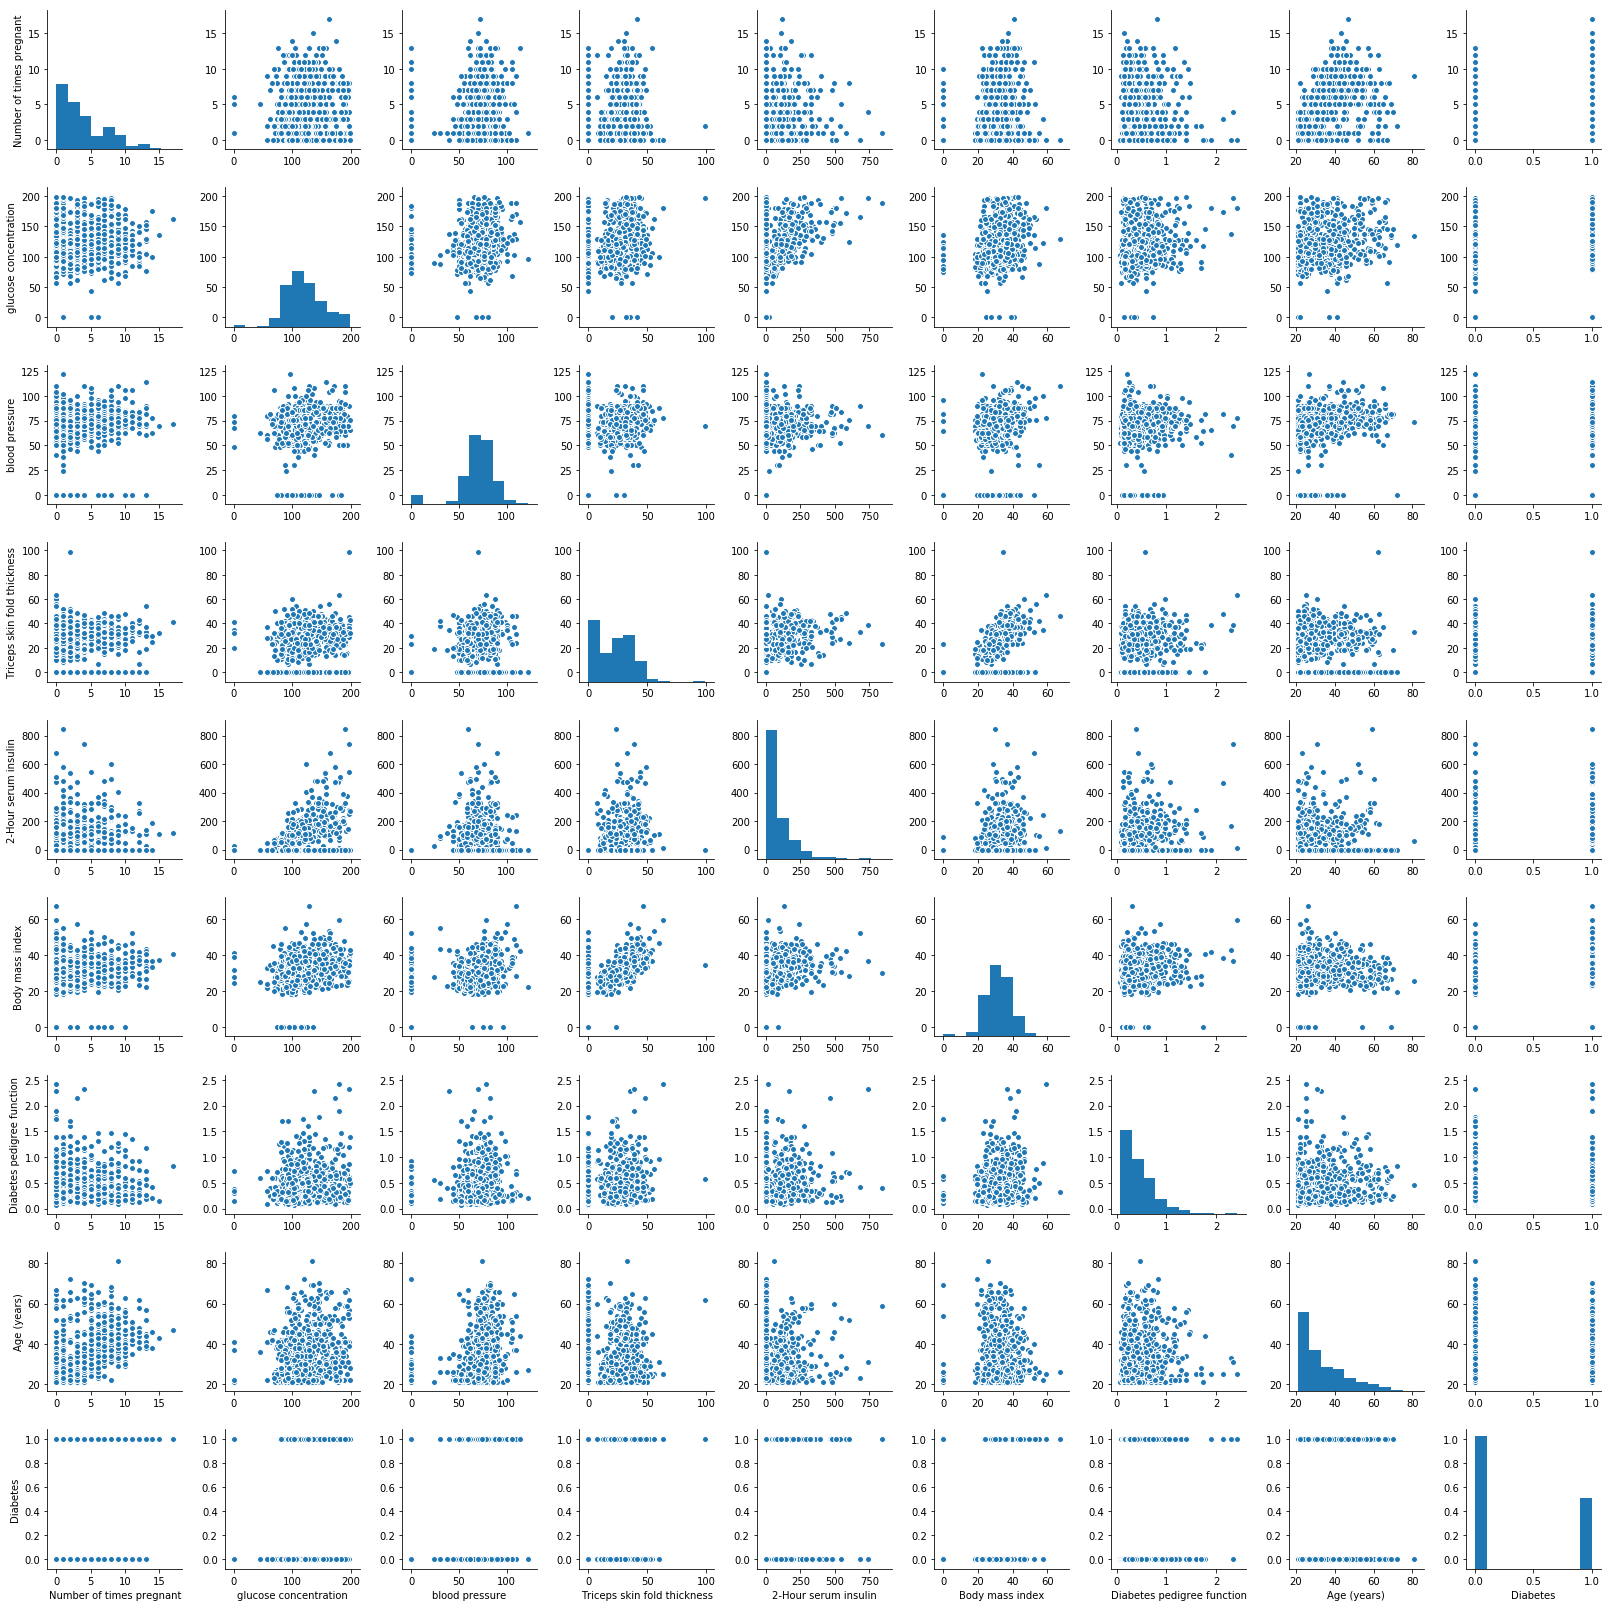

In [8]:
sns.pairplot(data)

We don't have categorical features in this dataset, so no need for any transformation.
Let's take a look at the correlation in the following matrix:

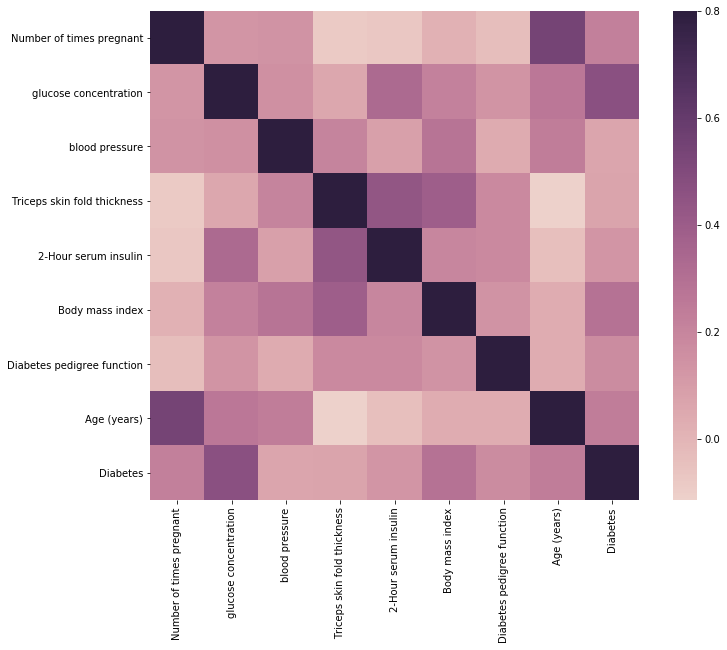

In [9]:
#correlation matrix
corrmat = data.corr()
cmap = sns.cubehelix_palette(8, as_cmap=True)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,cmap=cmap);

This visualization is interesting to understand the relationships between each pair of features.If we look at the last column, 'Diabetes' is the variable we are trying to predict, then, it's interesting to see that 'Glucose concentration' and Body mass index are the two most correlated features.
Let's try to dig in deeper and check the top 5 features with respect to 'Diabetes'.

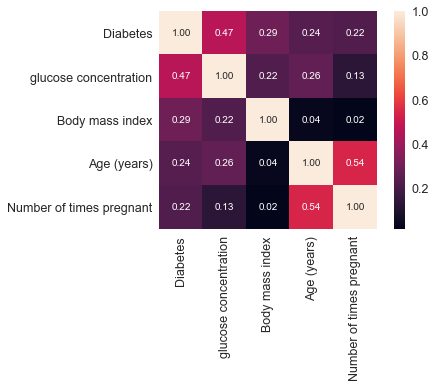

In [10]:
#amount correlation matrix
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Diabetes')['Diabetes'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The highest correlation is for glucose concentration, then body mass index and then Age and finally number of times pregnant.

### Missing data
Let's now take a look at the missing data in our dataset.

In [11]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Diabetes,0,0.0
Age (years),0,0.0
Diabetes pedigree function,0,0.0
Body mass index,0,0.0
2-Hour serum insulin,0,0.0
Triceps skin fold thickness,0,0.0
blood pressure,0,0.0
glucose concentration,0,0.0
Number of times pregnant,0,0.0


this are great news! No Missing data in our dataset. Let's now focus on the training stage.
# Training stage
Let's split the data into 80% for training and 20% for validation.

In [12]:
X = data.drop('Diabetes',axis=1)

In [13]:
y = data['Diabetes']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
cls = SVC()

In [16]:
cls.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
pred = cls.predict(X_test)

In [18]:
accuracy = accuracy_score(y_test,pred)

In [19]:
print(accuracy)

0.642857142857
